Austin Flippo

Data Science Jobs EDA (dataset from Kaggle)

In [1]:
import pandasql
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#reusable function for running queries
run_query = lambda query: sqldf(query, globals())

In [4]:
#dataset of Data Science Jobs From Indeed from Kaggle
df = pd.read_csv('Indeed-Data Science Jobs List.csv')
print(df.columns.values)

['Position' 'Job Title' 'Company' 'Location' 'Salary' 'Short Description'
 'Posted At' 'Job link']


In [5]:
query_1 = 'SELECT * FROM df'

In [6]:
#most common job title
most_common_query = """
            SELECT `Job Title`, COUNT(*) as count 
            FROM df 
            GROUP BY `Job Title` HAVING count > 1 
            ORDER BY count 
            DESC LIMIT 5
    """
run_query(most_common_query)

,Job Title,count
0,Data Scientist,55
1,Senior Data Scientist,20
2,Sr. Data Scientist,6
3,Sr Data Scientist,4
4,Data Scientist II,4


In [7]:
#turn salary string into integer
#purpose: in order to make calculations with salaries, they must be converted to numbers
def salary_to_int(sal):
    l_sal = "".join(c for c in sal if c.isdecimal() or c == ' ').split(' ')
    l_sal = list(map(int, filter(None, l_sal)))

    #if given a range, return the mean 
    if len(l_sal) > 1:
        return round((l_sal[0] +l_sal[-1])/2)
    else:
        return l_sal[0]

In [8]:
#dataframe with salaries as integers
sal_query = """
            SELECT `Job Title`, Company, salary 
            FROM df 
            WHERE Salary IS NOT NULL
            """
#create place holder dataframe called t_df, to not edit df
t_df = run_query(sal_query)
t_df['Salary'] = t_df['Salary'].apply(lambda sal: salary_to_int(sal))
t_df

,Job Title,Company,Salary
0,Data Scientist,Robert Half,130000
1,Data Scientist,US Office of Personnel Management,135372
2,Data Scientist,Ropes & Gray LLP,137500
3,Data Scientist,Long Beach City College,126133
4,Data Scientist,National Space Defense Center (NSDC),113456
...,...,...,...
57,Data Scientist - Full Scope Poly,Momentum,180000
58,Database/Data Scientist,"Goldbelt, Inc.",135625
59,Data Scientist,SRS Distribution - McKinney,98450
60,Statistical Programmer ONSITE,Maxis Clinical Sciences,107500


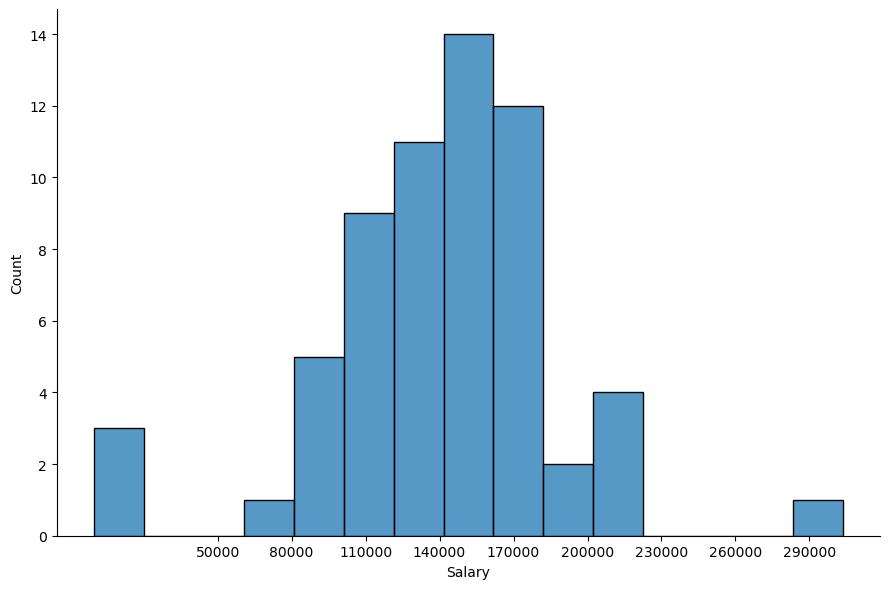

In [9]:
#distribution of salaries
dist = sns.displot(data=t_df, x = 'Salary', bins = 15, height = 6, aspect = 1.5)
plt.xticks(ticks=range(50000,300001,30000));


In [10]:
#summary statistics
avg_sal_query = """
            SELECT ROUND(AVG(salary),2) as `Average Salary`
            FROM t_df
            """
q = run_query(avg_sal_query).values
print('Avg Salary is $' + str(q[0][0])) 

sal_median = t_df['Salary'].median()
sal_std = t_df['Salary'].std()

print('Salary Median is $' + str(sal_median))
print('Salary Standard Deviation is $' + str(round(sal_std,2)))

Avg Salary is $139486.08
Salary Median is $144775.0
Salary Standard Deviation is $49517.33


Average Salary in Data Science Field: $152,679.55

68% of jobs lie within $105,297.64 - 200,061.46

90% of jobs lie within $57,915.73 - 247,443.37


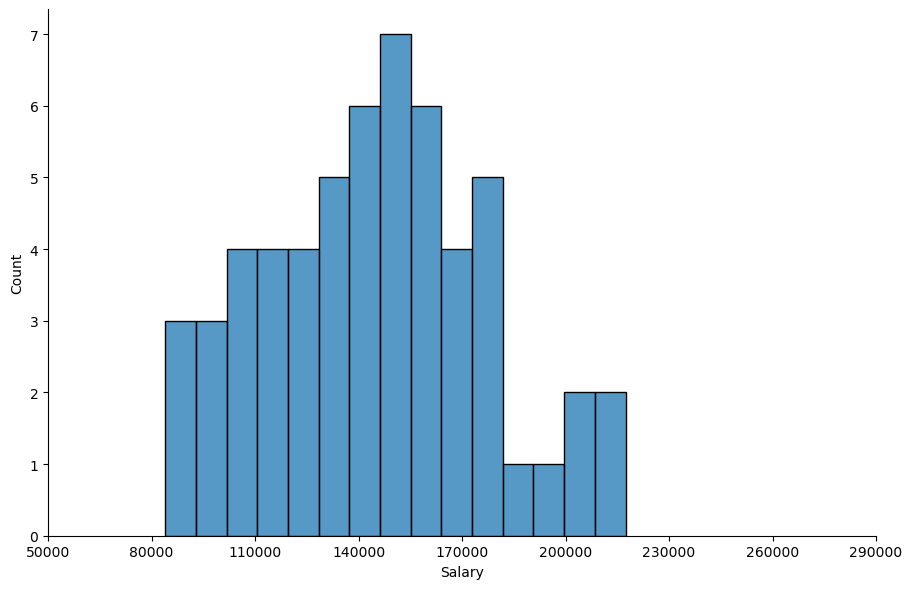

In [11]:
#distrubtion with outliers removed 
no_outliers_df = t_df[(t_df['Salary'] <= 290000) & (t_df['Salary']>80000)]
dist = sns.displot(data=no_outliers_df, x = 'Salary', bins = 15, height = 6, aspect = 1.5)
plt.xticks(ticks=range(50000,300001,30000));


In [12]:
#summary statistics with outliers removed
avg_sal_query = """
            SELECT ROUND(AVG(salary),2) as `Average Salary`
            FROM no_outliers_df
            """
q = run_query(avg_sal_query).values
print('Average Salary is $' + str(q[0][0]))

sal_median = no_outliers_df['Salary'].median()
sal_std = no_outliers_df['Salary'].std()

print('Salary Median is $' + str(sal_median))
print('Salary Standard Deviation is $' + str(round(sal_std,2)))


Average Salary is $145181.02
Salary Median is $145675.0
Salary Standard Deviation is $32326.65


Excluding outlier salary of $303,450...

68% of jobs lie within $111,344.67 - 179,655.33

90% of jobs lie within $77,189.34 - 213,810.66


In [13]:
#10 highest paying jobs
top_salaries_query = """
            SELECT `Job Title`, Company, salary
            FROM t_df
            ORDER BY salary DESC
            LIMIT 10
            """
run_query(top_salaries_query)

,Job Title,Company,Salary
0,"Executive, Data Scientist",USAA,303450
1,Data Scientist (All Levels),Noblis,217362
2,"Data Scientist, Data Strategy and Analytics",Abbott Laboratories,216200
3,"Senior Data Scientist, Lodging Pricing",Hopper,205000
4,Staff Data Scientist,Adobe,203900
5,Data Scientist - Marketing Mix Models,Verizon,196000
6,"Senior Data Scientist, Generative AI",Scale AI,189000
7,Data Scientist - Full Scope Poly,Momentum,180000
8,Senior Data Scientist,Autodesk,178000
9,Data Scientist,Peraton,175500


In [14]:
#Top 10 companies with highest paying jobs on average, and their number of jobs

top_3_query = """
            SELECT Company, AVG(Salary) as `Average Salary`, COUNT(*) as `Job Count`
            FROM t_df
            GROUP BY Company 
            ORDER BY 2 DESC
            LIMIT 10
            """
run_query(top_3_query)

,Company,Average Salary,Job Count
0,USAA,303450.0,1
1,Noblis,217362.0,1
2,Abbott Laboratories,216200.0,1
3,Hopper,205000.0,1
4,Verizon,196000.0,1
5,Scale AI,189000.0,1
6,Momentum,180000.0,1
7,Autodesk,178000.0,1
8,Adobe,177000.0,2
9,Peraton,175500.0,1


In [15]:
#function that returns location if the location is near me, or remote
#purpose: to grab the jobs close to home
def search_location(loc):
    keywords = [' 90', 'Los Angeles', 'LA', 'Remote', ' CA', 'California']
    for k in keywords:
            if type(loc) == str:
                if k in loc:
                    return loc

In [16]:
#search for jobs in California, or remote
l_df = df
l_df['Location'] = df['Location'].apply(lambda loc: search_location(loc))
l_df.dropna(subset=['Location'],inplace=True)

near_jobs_query = """
            SELECT `Job Title`, Salary, Location, `Job Link`
            FROM l_df
             
            
            """

run_query(near_jobs_query)

,Job Title,Salary,Location,Job link
0,Data Scientist,"$120,000 - $140,000 a year","Remote in Los Angeles, CA 90024",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,Data Scientist,"$103,409 - $167,336 a year",Remote,https://www.indeed.com/rc/clk?jk=d393197b7bc42...
2,Data Scientist,None,Remote in Colorado,https://www.indeed.com/rc/clk?jk=258a205f5e303...
3,Data Scientist,"$106,779 - $145,487 a year","Long Beach, CA 90808 \n(Lakewood Village area)",https://www.indeed.com/rc/clk?jk=d8685d06c8699...
4,Systems Engineer,"$115,764 - $120,000 a year","Dublin, CA 94568",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
5,Data Scientist I,None,"Hybrid work in Campbell, CA 95008",https://www.indeed.com/rc/clk?jk=795023c034e63...
6,Clinical Data Scientist,None,Remote,https://www.indeed.com/rc/clk?jk=e45e0ec028e3d...
7,Data Scientist,"$80,000 - $150,000 a year",Remote in Missouri,https://www.indeed.com/rc/clk?jk=7f6039ca6056e...
8,Associate Data Scientist,None,"Remote in Portland, OR",https://www.indeed.com/rc/clk?jk=0ac4e7a84594b...
9,"Associate Data Scientist, RWE Clinical Trials ...",None,"Remote in Deerfield, IL 60015",https://www.indeed.com/rc/clk?jk=0535c1945f4f3...
